# Sequential Monte Carlo with two gaussians

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

from pymc3.step_methods import smc
import theano.tensor as tt
import shutil

plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.7


Sampling from $n$-dimensional distributions with multiple peaks with a standard Metropolis-Hastings algorithm can be difficult, if not impossible, as the Markov chain often gets stuck in either of the minima.

A Sequential Monte Carlo sampler (SMC) is a way to overcome this problem, or at least to ameliorate it. SMC samplers are very similar to genetic algorithms, which are biologically-inspired algorithms that can be summarized as follows:

1. Initialization: set a population of individuals
2. Mutation: individuals are somehow modified or perturbed
3. Selection: individuals with high _fitness_ have higher chance to generate _offspring_.
4. Iterate by using individuals from 3 to set the population in 1.

If each _individual_ is a particular solution to a problem, then a genetic algorithm will eventually produce good solutions to that problem. One key aspect is to generate enough diversity (mutation step) to explore the solution space avoiding getting trap in local minima and then apply _selection_ to _probabilistically_ keep reasonable solutions while also keeping some diversity. Being too greedy and short-sighted could be problematic, _bad_ solutions in a given moment could lead to _good_ solutions in the future.

Moving into the realm of Bayesian statistics each individual is a point in the _posterior space_, mutations can be done in several ways, a general solution is to use a MCMC method (like Metropolis-Hastings) and run many Markov chains in parallel. The _fitness_ is given by the posterior, points with low posterior density will be removed and points high posterior density will be used as the starting point of a next round of Markov chains (This step is known as _reweighting_ in the SMC literature). The size of the population is kept fixed at some predefined value, so if a point is removed some other point should be used to start at least two new Markov chains.

The previous paragraph is summarized in the next figure, the first subplot show 5 samples (orange dots) at some particular stage. The second subplots show how this samples are reweighted according to the their posterior density (blue Gaussian curve). The third subplot shows the result of running a certain number of Metropolis steps, starting from the _selected/reweighting_ samples in the second subplots, notice how the two samples with the lower posterior density (smaller circles) are discarded and not used to seed Markov chains.

![SMC stages](https://github.com/pymc-devs/pymc3/raw/master/docs/source/notebooks/smc.png)

So far we have that the SMC sampler is just a bunch of parallel Markov chains, not very impressive, right? Well not that fast. SMC proceed by moving _sequentially_ trough a series of stages, starting from a simple to sample distribution until it get to the posterior distribution. All this intermediate distribution (or _tempered posterior distributions_) are controlled by _tempering_ parameter called $\beta$. SMC takes this idea from other _tempering_ methods originated from a branch of physics known as _statistical mechanics_. The idea is as follow the number of accessible states a _real physical_ system can reach is controlled by the temperature, if the temperature is the lowest possible ($0$ Kelvin) the system is trapped in a single state, on the contrary if the temperature is $\infty$ all states are equally accessible! In the _statistical mechanics_ literature $\beta$ is know as the inverse temperature, the higher the more constrained the system is. Going back to the Bayesian statistics context a _natural_ analogy to these physical systems is given by the following formula:

$$p(\theta \mid y)_{\beta} \propto p(y \mid \theta)^{\beta} p(\theta)$$

When $\beta = 0$, the _tempered posterior_ is just the prior and when $\beta=1$ the _tempered posterior_ is the true posterior. SMC starts with $\beta = 0$ and progress by always increasing the value of $\beta$, at each stage, until it reach 1. This is represented in the avobe figure by a narrower Gaussian distribution in the third subplot.

For the SMC version implemented in PyMC3 the number of chains is the number of draws. At each stage SMC will use independent Markov chains to explore the _tempered posterior_ (the black arrow in the figure). The final samples, _i.e_ those stored in the `trace`, will be taken exclusively from the final stage ($\beta = 1$), i.e. the true posterior.

The successive values of $\beta$ are determined automatically from the sampling results of the previous intermediate distribution. SMC will try to keep the effective samples size (ESS) constant. Thus, the harder the distribution is to sample the larger the number of stages SMC will take. In other words the _cooling_ will be slow and the successive values of $\beta$ will change in small steps.

Two more parameters that are automatically determined are:
* The number of steps each Markov chain takes to explore the _tempered posterior_ (`n_steps`) is determined from the acceptance rate at each stage, SMC use a _tune_interval_ to do this.
* The width of the proposal distribution (`MultivariateProposal`) is also adjusted adaptively based on the  acceptance rate at each stage.


Even when SMC uses the Metropolis-Hasting algorithm under the hood, it has several advantages over it:

* It can sample from $n$-dimensional distributions with multiple peaks.
* It does not have a burn-in period, it starts by sampling directly from the prior and then at each stage the starting points are already distributed according to the tempered posterior (due to the re-weighting step).
* It is inherently parallel.

To see an example of how to use SMC inside PyMC3 let's define a multivariate gaussian of dimension $n$, their weights and the covariance matrix. 

In [2]:
n = 4

mu1 = np.ones(n) * (1. / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.1
w2 = (1 - w1)

The PyMC3 model.  Note that we are making two gaussians, where one has `w1` (90%) of the mass:

In [3]:
def two_gaussians(x):
    log_like1 = - 0.5 * n * tt.log(2 * np.pi) \
                - 0.5 * tt.log(dsigma) \
                - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    log_like2 = - 0.5 * n * tt.log(2 * np.pi) \
                - 0.5 * tt.log(dsigma) \
                - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    return tt.log(w1 * tt.exp(log_like1) + w2 * tt.exp(log_like2))


with pm.Model() as model:
    X = pm.Uniform('X',
                   shape=n,
                   lower=-2. * np.ones_like(mu1),
                   upper=2. * np.ones_like(mu1),
                   testval=-1. * np.ones_like(mu1))
    llk = pm.Potential('llk', two_gaussians(X))
    trace = pm.sample(2000, step=pm.SMC())

Sample initial stage: ...
Stage: 0 Beta: 0.010 Steps: 25
Stage: 1 Beta: 0.029 Steps: 13
Stage: 2 Beta: 0.067 Steps: 3
Stage: 3 Beta: 0.146 Steps: 11
Stage: 4 Beta: 0.307 Steps: 4
Stage: 5 Beta: 0.623 Steps: 14
Stage: 6 Beta: 1.000 Steps: 4


Plotting the results using the traceplot:

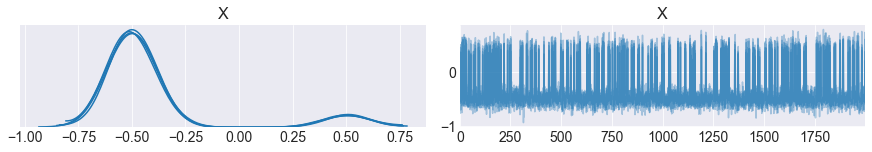

In [4]:
pm.traceplot(trace);